##Implementing LDA in Python


Importing the Required Libraries


In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 600)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.6)
import spacy
import random
from gensim import models, corpora, similarities
from wordcloud import WordCloud
import zipfile
import os
from gensim.models import TfidfModel, Doc2Vec
from gensim.models.doc2vec import TaggedDocument



Loading the dataset

In [3]:
# Open the zip file
with zipfile.ZipFile("spotify_songs.zip", "r") as zip_ref:
    # Extract the file to a temporary directory
    zip_ref.extractall("temp")

In [4]:
# Read the CSV file into a pandas DataFrame
songs = pd.read_csv("/content/temp/spotify_millsongdata.csv")

# Print head
songs.head(2)

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nAnd it means something special to me \r\nLook at the way that she smiles when she sees me \r\nHow lucky can one fellow be? \r\n \r\nShe's just my kind of girl, she makes me feel fine \r\nWho could ever believe that she could be mine? \r\nShe's just my kind of girl, without her I'm blue \r\nAnd if she ever leaves me what could I do, what could I do? \r\n \r\nAnd when we go for a walk in the park \r\nAnd she holds me and squeezes my hand \r\nWe'll go on walking for hours and talking \r\nAbout all the things that we plan \r\n \r\nShe'..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gently like a summer evening breeze \r\nTake your time, make it slow \r\nAndante, Andante \r\nJust let the feeling grow \r\n \r\nMake your fingers soft and light \r\nLet your body be the velvet of the night \r\nTouch my soul, you know how \r\nAndante, Andante \r\nGo slowly with me now \r\n \r\nI'm your music \r\n(I am your music and I am your song) \r\nI'm your song \r\n(I am your music and I am your song) \r\nPlay me time and time again and make me strong \r\n(Play me again 'cause you're making me strong) \r\nMake me sing, make m..."


In [5]:
data = list(songs["text"])
data = data[0:20000]

# Print length and example
print("Number of songs:", len(data))
print("\nFirst song:", data[0])

Number of songs: 20000

First song: Look at her face, it's a wonderful face  
And it means something special to me  
Look at the way that she smiles when she sees me  
How lucky can one fellow be?  
  
She's just my kind of girl, she makes me feel fine  
Who could ever believe that she could be mine?  
She's just my kind of girl, without her I'm blue  
And if she ever leaves me what could I do, what could I do?  
  
And when we go for a walk in the park  
And she holds me and squeezes my hand  
We'll go on walking for hours and talking  
About all the things that we plan  
  
She's just my kind of girl, she makes me feel fine  
Who could ever believe that she could be mine?  
She's just my kind of girl, without her I'm blue  
And if she ever leaves me what could I do, what could I do?




In [6]:
# Clean text
clean_data = [i.replace('\n','').replace('\r','') for i in data]


In [7]:
# Load English language model
nlp = spacy.load("en_core_web_sm")
unwanted_pipes = ["ner", "parser"]

# Custom tokenizer using spacy
def custom_tokenizer(doc):
    with nlp.disable_pipes(*unwanted_pipes):
        return [t.lemma_ for t in nlp(doc) if t.is_alpha and not t.is_space and not t.is_punct and not t.is_stop and t.pos_ in ["ADJ","NOUN","VERB"]]

To speed up tokenization, we'll use spacy's nlp.pipe function, which allows for processing multiple batches in parallel.

In [8]:
%%time

# Tokenize data
tokenized_data = list(map(custom_tokenizer, nlp.pipe(clean_data, n_process=4)))

# Print example
print(tokenized_data[0])

['look', 'face', 'wonderful', 'face', 'mean', 'special', 'look', 'way', 'smile', 'see', 'lucky', 'fellow', 'kind', 'girl', 'make', 'feel', 'fine', 'believe', 'kind', 'girl', 'blue', 'leave', 'walk', 'park', 'hold', 'squeeze', 'hand', 'walk', 'hour', 'talk', 'thing', 'plan', 'kind', 'girl', 'make', 'feel', 'fine', 'believe', 'kind', 'girl', 'blue', 'leave']
CPU times: user 10min 27s, sys: 6.14 s, total: 10min 33s
Wall time: 18min 43s


In [9]:
# Build dictionary of (token, ID) mappings
dct = corpora.Dictionary(tokenized_data)

# Print vocab size
print('Size of vocabulary before filtering:', len(dct))

# Filter overly low and high frequency tokens
dct.filter_extremes(no_below=5, no_above=0.5)

# Print vocab size
print('\nSize of vocabulary after filtering:', len(dct))

# Example mappings
print("\nExample mappings:", [(i,dct.token2id[i]) for i in tokenized_data[0][:10]])

Size of vocabulary before filtering: 27754

Size of vocabulary after filtering: 7702

Example mappings: [('look', 12), ('face', 2), ('wonderful', 26), ('face', 2), ('mean', 15), ('special', 20), ('look', 12), ('way', 25), ('smile', 19), ('see', 18)]


In [10]:
# Bag-of-Words sparse matrix
bow_vectors = [dct.doc2bow(i) for i in tokenized_data]

In [11]:
print(bow_vectors[0])

[(0, 2), (1, 2), (2, 2), (3, 2), (4, 1), (5, 2), (6, 4), (7, 1), (8, 1), (9, 1), (10, 4), (11, 2), (12, 2), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1)]


In [12]:
# Create TF-IDF representation
tfidf_model = TfidfModel([dct.doc2bow(doc) for doc in tokenized_data])
tfidf_vectors = [tfidf_model[dct.doc2bow(doc)] for doc in tokenized_data]

In [13]:
print(tfidf_vectors[0])

[(0, 0.18635594311225936), (1, 0.2118921048827152), (2, 0.17150981161301376), (3, 0.11030725600062109), (4, 0.23957786504535533), (5, 0.2600890273051169), (6, 0.3259434379792934), (7, 0.08129645657524086), (8, 0.07975509928780564), (9, 0.14372886699687362), (10, 0.5057935749834224), (11, 0.13431888037137824), (12, 0.11813850434681769), (13, 0.18322375925843593), (14, 0.20662588113936964), (15, 0.10272802550212058), (16, 0.19215554056754516), (17, 0.14884124205569652), (18, 0.08889155340761895), (19, 0.1055042050545957), (20, 0.18114134805341636), (21, 0.21236373071361328), (22, 0.10111363952304563), (23, 0.0636827431243945), (24, 0.16971876239973377), (25, 0.05301559995287909), (26, 0.193183466894756)]


In [14]:
# Train Doc2Vec model
tagged_documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(tokenized_data)]
doc2vec_model = Doc2Vec(vector_size=100, window=2, min_count=1, workers=4)
doc2vec_model.build_vocab(tagged_documents)
doc2vec_model.train(tagged_documents, total_examples=doc2vec_model.corpus_count, epochs=10)

# Get Doc2Vec vectors
doc2vec_vectors = [doc2vec_model.infer_vector(doc) for doc in tokenized_data]

In [29]:
print(doc2vec_vectors[0])

[-0.09528007 -0.22473422  0.06955331  0.2810689  -0.43348604 -0.02465928
  0.19177857  0.2770189  -0.3659776  -0.09698877  0.38297248 -0.00498966
  0.00289704  0.03875118 -0.27458385  0.0781323   0.08848499 -0.00493572
  0.21507733 -0.08034881 -0.4908354   0.32487416 -0.12480648 -0.05808063
 -0.12565398 -0.09725143  0.11189008 -0.21454674  0.21162392 -0.17107277
  0.09606814 -0.11593832  0.06154561  0.2542841  -0.25041294  0.19001767
  0.09298773  0.00473349  0.2759498  -0.03907464  0.1825615   0.08992977
 -0.18798202 -0.5250446  -0.01631991 -0.4350777  -0.33066648  0.13231039
  0.17970459  0.19193183  0.17549063  0.23081979 -0.15704228  0.30722016
  0.45653185  0.5055375   0.318086   -0.10230589  0.03617576 -0.02081983
  0.34217635 -0.05798195 -0.05534549  0.11963471 -0.147287    0.01852509
  0.18644604 -0.44284755 -0.11955909  0.05506479  0.20466664 -0.00885755
  0.28226846  0.1968896  -0.62144685 -0.01249149  0.17586832  0.07095489
 -0.12328294 -0.1348648   0.09488828  0.2973921   0

In [30]:
%%time

# Train LDA model
lda_model_bow = models.LdaModel(corpus=bow_vectors, num_topics=10, passes=10, alpha='auto', eta='auto', id2word=dct, random_state=0)

CPU times: user 1min 45s, sys: 1.74 s, total: 1min 46s
Wall time: 1min 47s


In [31]:
lda_model_bow.print_topics()


[(0,
  '0.020*"heart" + 0.019*"life" + 0.015*"lose" + 0.014*"time" + 0.014*"eye" + 0.014*"turn" + 0.013*"leave" + 0.013*"live" + 0.013*"find" + 0.013*"world"'),
 (1,
  '0.045*"man" + 0.015*"hand" + 0.011*"people" + 0.011*"mother" + 0.010*"dead" + 0.009*"blood" + 0.009*"child" + 0.009*"great" + 0.008*"kill" + 0.008*"young"'),
 (2,
  '0.114*"baby" + 0.063*"girl" + 0.055*"little" + 0.034*"come" + 0.033*"tonight" + 0.026*"go" + 0.024*"cry" + 0.021*"night" + 0.020*"leave" + 0.018*"tell"'),
 (3,
  '0.035*"look" + 0.031*"walk" + 0.029*"town" + 0.026*"black" + 0.022*"street" + 0.022*"ready" + 0.020*"ride" + 0.018*"bear" + 0.017*"white" + 0.017*"city"'),
 (4,
  '0.036*"come" + 0.033*"day" + 0.025*"night" + 0.021*"dream" + 0.017*"light" + 0.013*"sun" + 0.013*"sky" + 0.012*"song" + 0.012*"sing" + 0.011*"rain"'),
 (5,
  '0.176*"go" + 0.036*"wanna" + 0.034*"like" + 0.031*"run" + 0.031*"dance" + 0.021*"way" + 0.019*"bad" + 0.018*"feel" + 0.011*"beat" + 0.009*"body"'),
 (6,
  '0.188*"love" + 0.071*"w

In [32]:
%%time

# Train LDA model
lda_model_tfidf = models.LdaModel(corpus=tfidf_vectors, num_topics=10, passes=10, alpha='auto', eta='auto', id2word=dct, random_state=0)

CPU times: user 44.1 s, sys: 434 ms, total: 44.5 s
Wall time: 44.8 s


In [33]:
lda_model_tfidf.print_topics()


[(0,
  '0.007*"receive" + 0.007*"na" + 0.007*"compare" + 0.006*"wipe" + 0.006*"destroy" + 0.005*"protect" + 0.005*"mix" + 0.005*"cowboy" + 0.005*"presence" + 0.005*"blessing"'),
 (1,
  '0.013*"praise" + 0.010*"bless" + 0.008*"yea" + 0.008*"loose" + 0.007*"lifetime" + 0.006*"misery" + 0.006*"enemy" + 0.006*"pocket" + 0.006*"scar" + 0.006*"gate"'),
 (2,
  '0.012*"love" + 0.008*"want" + 0.008*"baby" + 0.008*"go" + 0.008*"get" + 0.007*"time" + 0.007*"let" + 0.007*"feel" + 0.006*"come" + 0.006*"heart"'),
 (3,
  '0.009*"stray" + 0.008*"deadly" + 0.007*"crying" + 0.007*"scent" + 0.007*"height" + 0.006*"riot" + 0.006*"reaction" + 0.006*"alibi" + 0.006*"threat" + 0.006*"closet"'),
 (4,
  '0.005*"sing" + 0.005*"dance" + 0.005*"roll" + 0.004*"rock" + 0.004*"light" + 0.004*"wind" + 0.004*"sky" + 0.004*"high" + 0.004*"music" + 0.004*"sea"'),
 (5,
  '0.010*"resist" + 0.010*"familiar" + 0.009*"thief" + 0.008*"meat" + 0.007*"inch" + 0.006*"satisfaction" + 0.006*"rearrange" + 0.006*"oo" + 0.006*"ad" + 

##Lets see how bow vs tfidf methods have gave diferent topic proportion






In [34]:
topics = list(lda_model_bow.get_document_topics(bow_vectors, minimum_probability=0))

# Print topic proportion in corpus
for i in range(10):
    print(f"Topic {i} proportion: {100*sum([pair[i][1] for pair in topics])/len(topics):.1f}%")

Topic 0 proportion: 21.0%
Topic 1 proportion: 7.1%
Topic 2 proportion: 7.8%
Topic 3 proportion: 4.1%
Topic 4 proportion: 17.6%
Topic 5 proportion: 5.1%
Topic 6 proportion: 14.3%
Topic 7 proportion: 14.1%
Topic 8 proportion: 6.7%
Topic 9 proportion: 2.3%


In [35]:
topics = list(lda_model_tfidf.get_document_topics(tfidf_vectors, minimum_probability=0))

# Print topic proportion in corpus
for i in range(10):
    print(f"Topic {i} proportion: {100*sum([pair[i][1] for pair in topics])/len(topics):.1f}%")

Topic 0 proportion: 2.6%
Topic 1 proportion: 4.3%
Topic 2 proportion: 60.3%
Topic 3 proportion: 0.5%
Topic 4 proportion: 27.5%
Topic 5 proportion: 1.1%
Topic 6 proportion: 0.8%
Topic 7 proportion: 0.4%
Topic 8 proportion: 1.9%
Topic 9 proportion: 0.5%


## EVALUATING TOPIC

In [36]:
# Coherence score
coherence_model = models.coherencemodel.CoherenceModel(model=lda_model_bow, texts=tokenized_data, dictionary=dct, coherence='u_mass')
coherence_score = coherence_model.get_coherence()
print(f'Coherence Score: {coherence_score:.4f}')

Coherence Score: -2.3476


In [37]:
perplexity = lda_model_bow.log_perplexity(bow_vectors)
print(f'Perplexity: {perplexity:.4f}')

Perplexity: -6.8237


In [38]:
# Coherence score
coherence_model = models.coherencemodel.CoherenceModel(model=lda_model_tfidf, texts=tokenized_data, dictionary=dct, coherence='u_mass')
coherence_score = coherence_model.get_coherence()
print(f'Coherence Score: {coherence_score:.4f}')

Coherence Score: -13.2287


In [39]:
# Calculate perplexity
perplexity = lda_model_tfidf.log_perplexity(tfidf_vectors)
print(f'Perplexity: {perplexity:.4f}')

Perplexity: -8.2425


Both Perplexity and Coherence score indicate tfidf model performs well

## Visualizing TOPICS

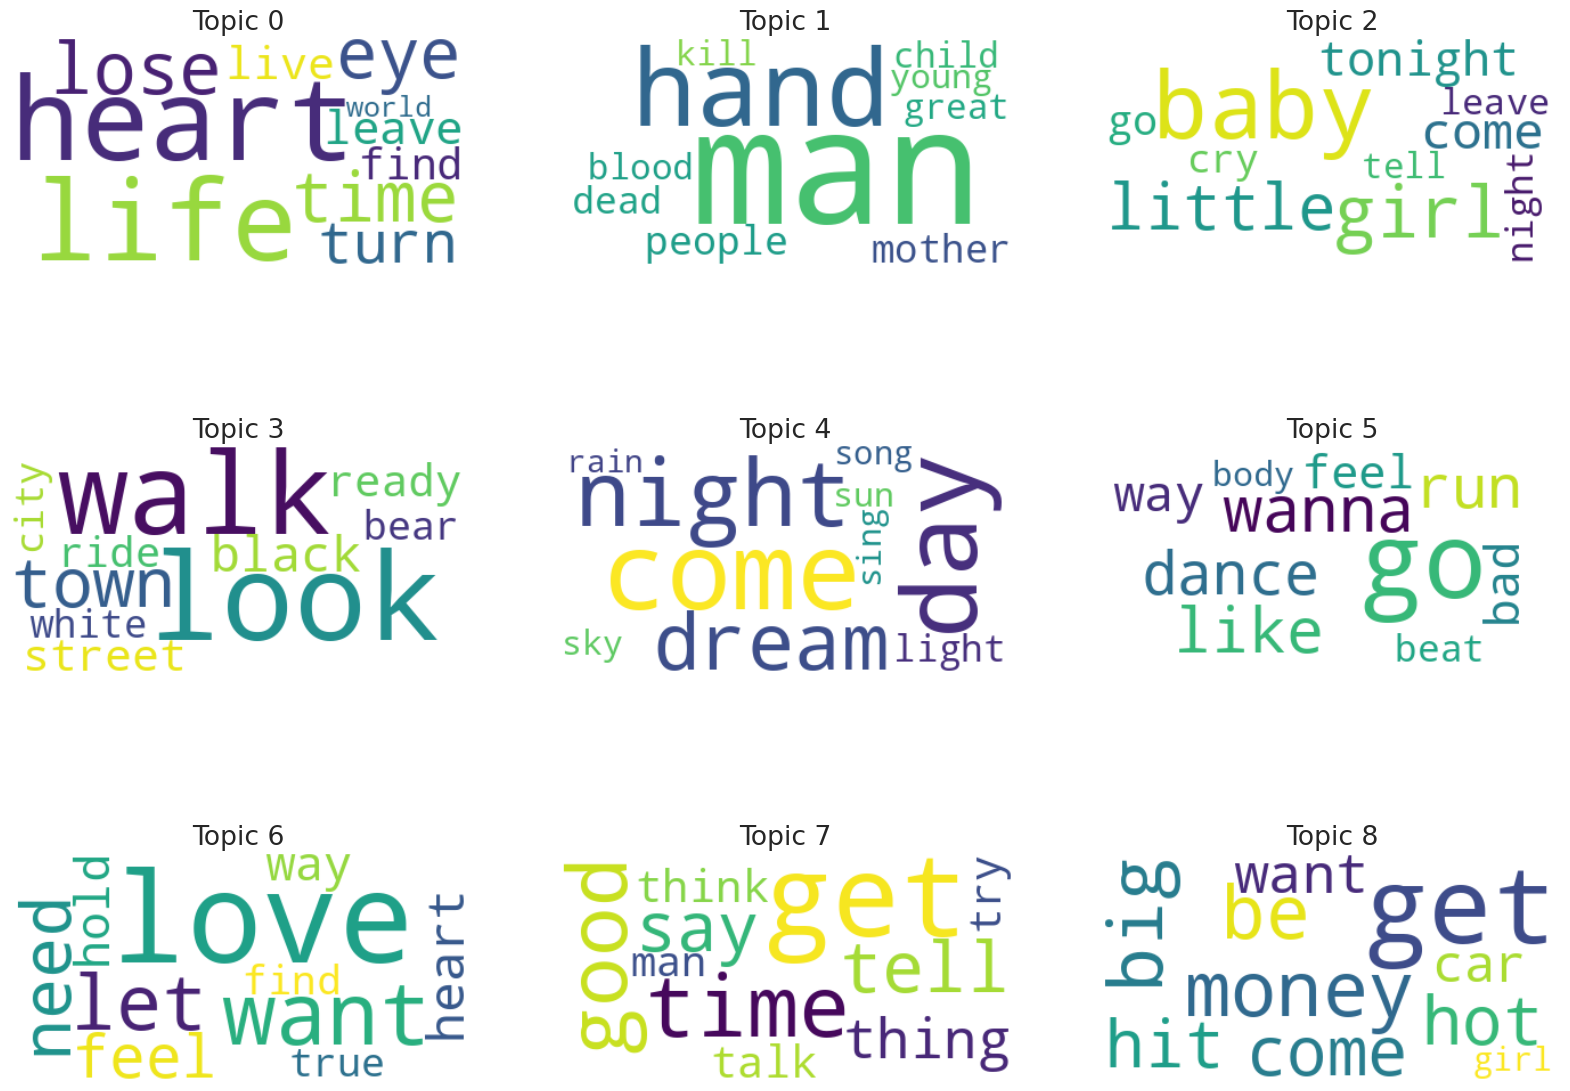

In [40]:
# Plot word clouds for each topic from bow method
word_cloud = WordCloud(background_color='white', max_words=10)
fig, axes = plt.subplots(3, 3, figsize=(20,15))

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(lda_model_bow.show_topic(i))
    word_cloud.generate_from_frequencies(topic_words)
    plt.gca().imshow(word_cloud, interpolation='bilinear')
    plt.gca().set_title(f'Topic {i}')
    plt.gca().axis('off')
plt.show()

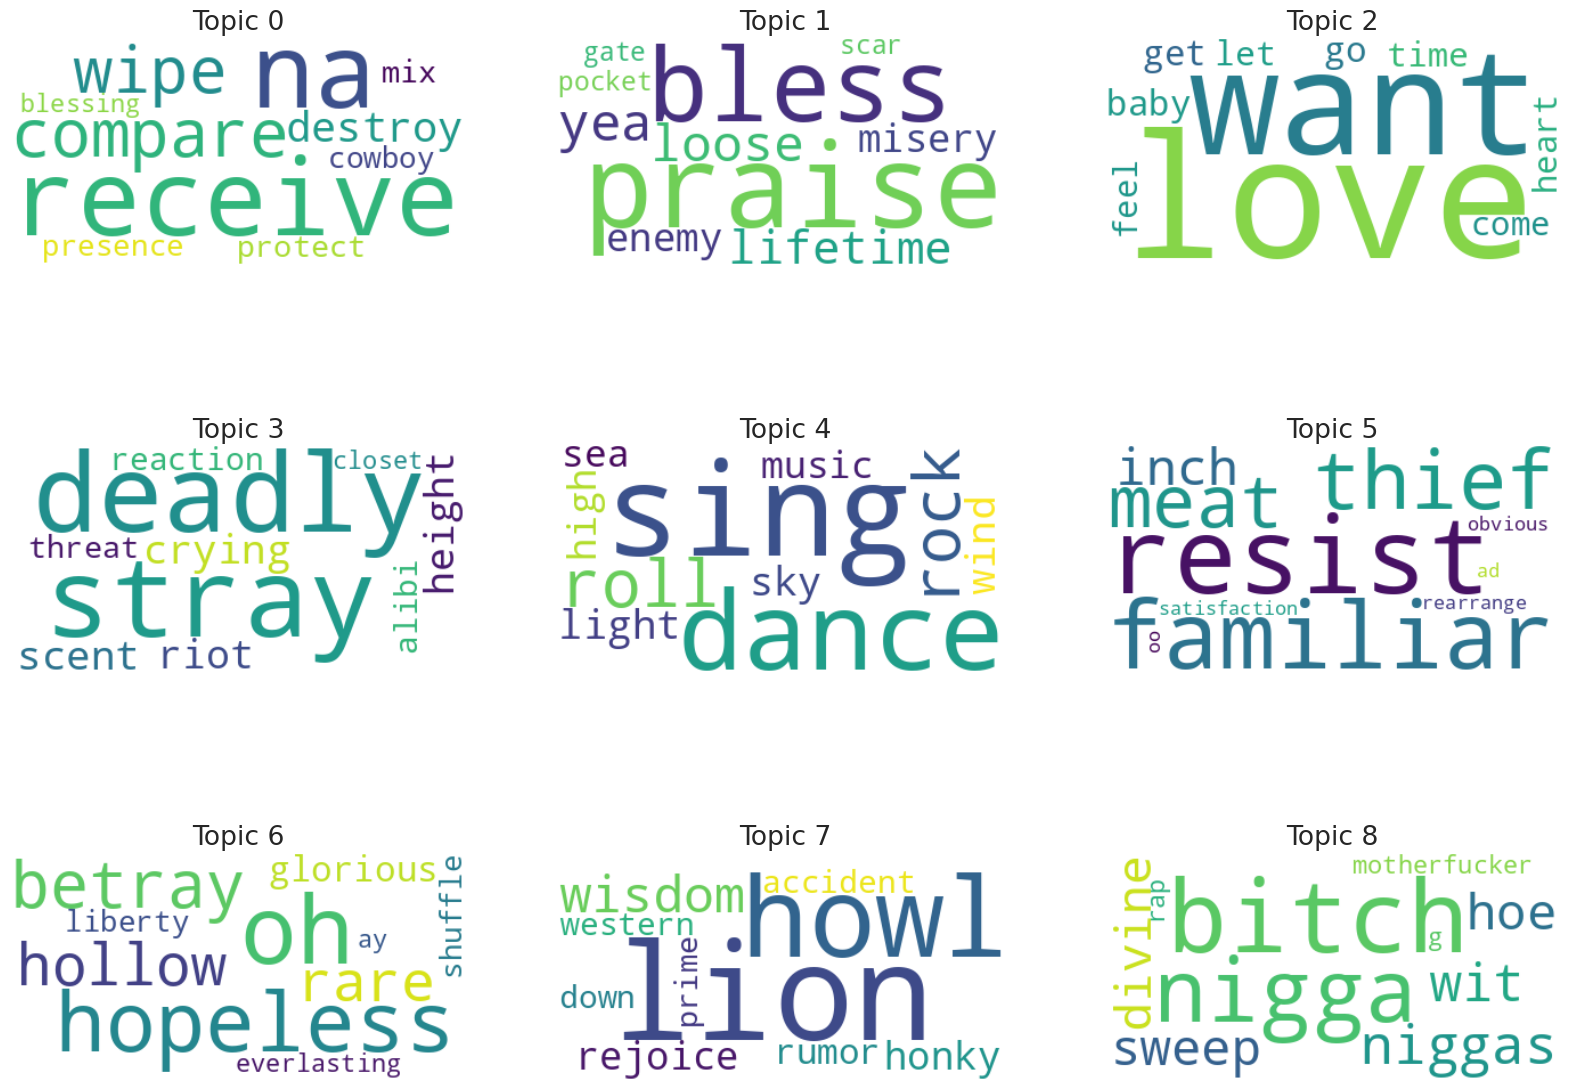

In [41]:
# Plot word clouds for each topic from tfidf method
word_cloud = WordCloud(background_color='white', max_words=10)
fig, axes = plt.subplots(3, 3, figsize=(20,15))

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(lda_model_tfidf.show_topic(i))
    word_cloud.generate_from_frequencies(topic_words)
    plt.gca().imshow(word_cloud, interpolation='bilinear')
    plt.gca().set_title(f'Topic {i}')
    plt.gca().axis('off')
plt.show()

In [43]:
pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 21.7 MB/s eta 0:00:00


In [44]:
import pyLDAvis
import pyLDAvis.gensim

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [45]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_bow, bow_vectors, dct, mds="mmds", R=30)
vis

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.024845  0.075779       1        1  20.260212
4      0.167394  0.232860       2        1  16.343077
7     -0.220007  0.022191       3        1  14.036930
6     -0.296697  0.209778       4        1  13.330636
8      0.053603 -0.335541       5        1   8.319475
1     -0.002153  0.394346       6        1   7.622249
2     -0.145309 -0.218708       7        1   7.615284
5     -0.340383 -0.174813       8        1   5.427322
3      0.306485 -0.246336       9        1   4.228844
9      0.452224  0.040445      10        1   2.815971, topic_info=     Term          Freq         Total Category  logprob  loglift
72   love  34175.000000  34175.000000  Default  30.0000  30.0000
123    go  20027.000000  20027.000000  Default  29.0000  29.0000
55   baby  11837.000000  11837.000000  Default  28.0000  28.0000
66    get  21675.000000  21675.000000  Default  27.0000  27.0000
202  want  16017.000000  16017.000000  Default  26.0000  26.0000
..    ...           ...           ...      ...      ...      ...
275  beat    242.665529   1771.580856  Topic10  -5.0603   1.5819
244  foot    222.562396   1571.824811  Topic10  -5.1468   1.6151
38    let    283.493087  13721.218854  Topic10  -4.9048  -0.3096
127   mad    185.716862    587.589408  Topic10  -5.3278   2.4181
560  flow    183.320721    756.103810  Topic10  -5.3408   2.1529

[734 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
772       1  0.005018  affair
772       2  0.005018  affair
772       4  0.843085  affair
772       6  0.065239  affair
772       7  0.085312  affair
...     ...       ...     ...
291       4  0.035302   young
291       6  0.536585   young
291       8  0.012837   young
291      10  0.019897   young
1054      9  0.992480     zoo

[2161 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 8, 7, 9, 2, 3, 6, 4, 10])